In [1]:
import dask
import dask.dataframe as dd
from dask.distributed import Client

from dask.diagnostics import ProgressBar

from url_parser import parse_url

client = Client()

2023-03-04 15:37:31,766 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-fjhxihlq', purging
2023-03-04 15:37:31,766 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-9h8lujo4', purging
2023-03-04 15:37:31,766 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-04nywbp7', purging
2023-03-04 15:37:31,766 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-ajt6s8wd', purging
2023-03-04 15:37:31,766 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-_wjfzb2w', purging
2023-03-04 15:37:31,766 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-oo0kt5k6', purging


In [2]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 24,Total memory: 125.60 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36383,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 24
Started: Just now,Total memory: 125.60 GiB
Comm: tcp://127.0.0.1:44073,Total threads: 4
Dashboard: http://127.0.0.1:40943/status,Memory: 20.93 GiB
Nanny: tcp://127.0.0.1:39945,


In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

pbar = ProgressBar()
pbar.register()
# GDELT CodeBook: http://data.gdeltproject.org/documentation/CAMEO.Manual.1.1b3.pdf

In [4]:
dat = dd.read_parquet("data/output")

In [5]:
only_us = dat[(dat.Actor1Code == "USA") & (dat.Actor2Code == "CHN")]
only_china = dat[(dat.Actor1Code == "CHN") & (dat.Actor2Code == "USA")]
dat.head()

,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,Actor1Religion1Code,Actor1Religion2Code,Actor1Type1Code,Actor1Type2Code,Actor1Type3Code,Actor2Code,Actor2Name,Actor2CountryCode,Actor2KnownGroupCode,Actor2EthnicCode,Actor2Religion1Code,Actor2Religion2Code,Actor2Type1Code,Actor2Type2Code,Actor2Type3Code,IsRootEvent,EventCode,EventBaseCode,EventRootCode,QuadClass,GoldsteinScale,NumMentions,NumSources,NumArticles,AvgTone,Actor1Geo_Type,Actor1Geo_FullName,Actor1Geo_CountryCode,Actor1Geo_ADM1Code,Actor1Geo_Lat,Actor1Geo_Long,Actor1Geo_FeatureID,Actor2Geo_Type,Actor2Geo_FullName,Actor2Geo_CountryCode,Actor2Geo_ADM1Code,Actor2Geo_Lat,Actor2Geo_Long,Actor2Geo_FeatureID,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
GLOBALEVENTID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
963548206,20201211,202012,2020,2020.9342,USAEDU,UNITED STATES,USA,None,None,None,None,EDU,None,None,EDU,SCHOOL,None,None,None,None,None,EDU,None,None,0,030,030,03,1,4.0,2,1,2,1.01522842639594,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,20210110,https://www.ktvb.com/article/news/health/coron...
963548207,20210103,202101,2021,2021.0082,None,None,None,None,None,None,None,None,None,None,MIL,NATIONAL GUARD,None,None,None,None,None,MIL,None,None,1,036,036,03,1,4.0,70,5,70,-4.75240042017015,0,None,None,None,None,None,None,2,"California, United States",US,USCA,36.17,-119.746,CA,2,"California, United States",US,USCA,36.17,-119.746,CA,20210110,https://www.mdjonline.com/tribune/lifestyles/a...
963548213,20210103,202101,2021,2021.0082,USA,UNITED STATES,USA,None,None,None,None,None,None,None,GOV,SECRETARY OF STATE,None,None,None,None,None,GOV,None,None,0,020,020,02,1,3.0,142,38,142,-4.17371166647743,3,"Atlanta, Georgia, United States",US,USGA,33.749,-84.388,351615,3,"Atlanta, Georgia, United States",US,USGA,33.749,-84.388,351615,3,"Atlanta, Georgia, United States",US,USGA,33.749,-84.388,351615,20210110,https://accesswdun.com/article/2021/1/969753
963548214,20210103,202101,2021,2021.0082,USA,OREGON,USA,None,None,None,None,None,None,None,USAMIL,OREGON,USA,None,None,None,None,MIL,None,None,1,080,080,08,2,5.0,6,1,6,1.01522842639594,3,"Washington, District of Columbia, United States",US,USDC,38.8951,-77.0364,531871,3,"Washington, District of Columbia, United States",US,USDC,38.8951,-77.0364,531871,3,"Washington, District of Columbia, United States",US,USDC,38.8951,-77.0364,531871,20210110,https://www.ktvb.com/article/news/health/coron...
963548215,20210103,202101,2021,2021.0082,USA,UNITED STATES,USA,None,None,None,None,None,None,None,USAMIL,UNITED STATES,USA,None,None,None,None,MIL,None,None,1,080,080,08,2,5.0,4,1,4,1.01522842639594,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,20210110,https://www.ktvb.com/article/news/health/coron...


In [6]:
topn = 100
urls = only_china[["SOURCEURL", "QuadClass"]].compute()
urls = urls.dropna()
print(urls)

                                                       SOURCEURL QuadClass
GLOBALEVENTID                                                             
963548586      https://www.cantonrep.com/story/tech/2021/01/0...         4
963550411      http://www.msn.com/en-nz/news/world/pompeo-lif...         1
963550412      http://www.msn.com/en-nz/news/world/pompeo-lif...         1
963550413      https://www.zerohedge.com/geopolitical/washing...         1
963550414      https://www.rnz.co.nz/news/world/434296/pompeo...         3
...                                                          ...       ...
972870556      https://thestandard.org.nz/biden-can-reset-wit...         1
972870557      https://www.bangkokpost.com/opinion/opinion/20...         1
972870558      https://www.bangkokpost.com/opinion/opinion/20...         1
972872413      https://www.azcentral.com/story/news/local/ari...         1
972872414      https://www.azcentral.com/story/news/local/ari...         1

[121585 rows x 2 columns

In [7]:
import re
import string
from urllib.parse import urlparse
from collections import Counter
import numpy as np

def clean_url(inp_url:str) -> str:
    url = urlparse(inp_url)
    translation_table = str.maketrans("", "", string.digits)
    return (re.sub(' +', ' ', url.path
                .replace(".html", "")
                .replace("/", " ")
                .replace("-", " ")
                .translate(translation_table)
                .strip()))
    
from tqdm import tqdm

print(len(urls))
cleaned_urls = urls["SOURCEURL"].apply(clean_url)
quad_class = np.array([int(n) for n in urls["QuadClass"].tolist()]).astype(int)
min_key, min_count = min(Counter(quad_class).items(), key=lambda x: x[1])
num_added = {x:0 for x in range(1, 5)}

count_norm_x = []
count_norm_y = []
for url, qc in zip(cleaned_urls, quad_class):
    if num_added[qc] <= min_count:
        count_norm_x.append(url)
        count_norm_y.append(qc)
        num_added[qc] += 1
        
print(len(count_norm_x), len(count_norm_y))
print(Counter(count_norm_y))

121585
49963 49963
Counter({4: 12491, 1: 12491, 3: 12491, 2: 12490})


In [8]:
from dask_ml.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [9]:
vectorizer = TfidfVectorizer(max_features=2**15)
X = vectorizer.fit_transform(count_norm_x)
X.shape

(49963, 25655)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, count_norm_y, test_size=0.2)

## Perceptron Multiclass Classification

In [11]:
from sklearn.linear_model import Perceptron

clf = Perceptron(tol=None, random_state=42, verbose=1, max_iter=1000)
clf = clf.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 61.68, NNZs: 14459, Bias: -0.140000, T: 39970, Avg. loss: 0.099034
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 77.86, NNZs: 16654, Bias: -0.160000, T: 79940, Avg. loss: 0.075686
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 89.56, NNZs: 17658, Bias: -0.220000, T: 119910, Avg. loss: 0.065029
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 98.52, NNZs: 18163, Bias: -0.230000, T: 159880, Avg. loss: 0.059753
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 106.52, NNZs: 18543, Bias: -0.150000, T: 199850, Avg. loss: 0.055922
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 112.93, NNZs: 18793, Bias: -0.120000, T: 239820, Avg. loss: 0.053155
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 118.84, NNZs: 19012, Bias: -0.050000, T: 279790, Avg. loss: 0.051420
Total training time: 0.02 seconds.
-- Epoch 8
Norm: 124.44, NNZs: 19180, Bias: -0.070000, T: 319760, Avg. loss: 0.049269
Total training time: 0.02 seconds.
-- Epoch 9
Norm: 129.05, NNZs: 19319, 

Norm: 297.56, NNZs: 20590, Bias: -0.060000, T: 4996250, Avg. loss: 0.036230
Total training time: 0.20 seconds.
-- Epoch 126
Norm: 298.31, NNZs: 20599, Bias: -0.030000, T: 5036220, Avg. loss: 0.036014
Total training time: 0.20 seconds.
-- Epoch 127
Norm: 299.09, NNZs: 20594, Bias: 0.010000, T: 5076190, Avg. loss: 0.036124
Total training time: 0.20 seconds.
-- Epoch 128
Norm: 299.87, NNZs: 20604, Bias: -0.020000, T: 5116160, Avg. loss: 0.036256
Total training time: 0.21 seconds.
-- Epoch 129
Norm: 300.57, NNZs: 20595, Bias: -0.050000, T: 5156130, Avg. loss: 0.036163
Total training time: 0.21 seconds.
-- Epoch 130
Norm: 301.28, NNZs: 20599, Bias: 0.010000, T: 5196100, Avg. loss: 0.036551
Total training time: 0.21 seconds.
-- Epoch 131
Norm: 302.01, NNZs: 20613, Bias: -0.020000, T: 5236070, Avg. loss: 0.035988
Total training time: 0.21 seconds.
-- Epoch 132
Norm: 302.73, NNZs: 20601, Bias: -0.010000, T: 5276040, Avg. loss: 0.036173
Total training time: 0.21 seconds.
-- Epoch 133
Norm: 303.

Norm: 376.49, NNZs: 20699, Bias: -0.030000, T: 10711960, Avg. loss: 0.034814
Total training time: 0.40 seconds.
-- Epoch 269
Norm: 376.85, NNZs: 20690, Bias: -0.050000, T: 10751930, Avg. loss: 0.035576
Total training time: 0.40 seconds.
-- Epoch 270
Norm: 377.28, NNZs: 20692, Bias: 0.020000, T: 10791900, Avg. loss: 0.034757
Total training time: 0.41 seconds.
-- Epoch 271
Norm: 377.74, NNZs: 20700, Bias: -0.080000, T: 10831870, Avg. loss: 0.034838
Total training time: 0.41 seconds.
-- Epoch 272
Norm: 378.15, NNZs: 20694, Bias: -0.020000, T: 10871840, Avg. loss: 0.036125
Total training time: 0.41 seconds.
-- Epoch 273
Norm: 378.57, NNZs: 20704, Bias: 0.010000, T: 10911810, Avg. loss: 0.035672
Total training time: 0.41 seconds.
-- Epoch 274
Norm: 378.97, NNZs: 20697, Bias: -0.030000, T: 10951780, Avg. loss: 0.034866
Total training time: 0.41 seconds.
-- Epoch 275
Norm: 379.33, NNZs: 20683, Bias: -0.060000, T: 10991750, Avg. loss: 0.035183
Total training time: 0.41 seconds.
-- Epoch 276
No

Norm: 428.90, NNZs: 20731, Bias: -0.010000, T: 16387700, Avg. loss: 0.034146
Total training time: 0.61 seconds.
-- Epoch 411
Norm: 429.24, NNZs: 20715, Bias: 0.020000, T: 16427670, Avg. loss: 0.034381
Total training time: 0.61 seconds.
-- Epoch 412
Norm: 429.57, NNZs: 20728, Bias: -0.010000, T: 16467640, Avg. loss: 0.034658
Total training time: 0.61 seconds.
-- Epoch 413
Norm: 429.88, NNZs: 20725, Bias: -0.060000, T: 16507610, Avg. loss: 0.034937
Total training time: 0.61 seconds.
-- Epoch 414
Norm: 430.19, NNZs: 20719, Bias: 0.000000, T: 16547580, Avg. loss: 0.034727
Total training time: 0.61 seconds.
-- Epoch 415
Norm: 430.52, NNZs: 20722, Bias: 0.040000, T: 16587550, Avg. loss: 0.034211
Total training time: 0.61 seconds.
-- Epoch 416
Norm: 430.84, NNZs: 20722, Bias: -0.010000, T: 16627520, Avg. loss: 0.034127
Total training time: 0.61 seconds.
-- Epoch 417
Norm: 431.18, NNZs: 20727, Bias: -0.170000, T: 16667490, Avg. loss: 0.034616
Total training time: 0.61 seconds.
-- Epoch 418
Nor

Norm: 470.07, NNZs: 20752, Bias: 0.020000, T: 22063440, Avg. loss: 0.034479
Total training time: 0.81 seconds.
-- Epoch 553
Norm: 470.32, NNZs: 20745, Bias: -0.030000, T: 22103410, Avg. loss: 0.033812
Total training time: 0.81 seconds.
-- Epoch 554
Norm: 470.57, NNZs: 20750, Bias: -0.030000, T: 22143380, Avg. loss: 0.034323
Total training time: 0.81 seconds.
-- Epoch 555
Norm: 470.84, NNZs: 20737, Bias: -0.060000, T: 22183350, Avg. loss: 0.033886
Total training time: 0.81 seconds.
-- Epoch 556
Norm: 471.08, NNZs: 20749, Bias: -0.050000, T: 22223320, Avg. loss: 0.034028
Total training time: 0.81 seconds.
-- Epoch 557
Norm: 471.36, NNZs: 20752, Bias: -0.020000, T: 22263290, Avg. loss: 0.034790
Total training time: 0.81 seconds.
-- Epoch 558
Norm: 471.58, NNZs: 20753, Bias: 0.010000, T: 22303260, Avg. loss: 0.034565
Total training time: 0.81 seconds.
-- Epoch 559
Norm: 471.88, NNZs: 20762, Bias: 0.010000, T: 22343230, Avg. loss: 0.033453
Total training time: 0.82 seconds.
-- Epoch 560
Nor

Norm: 504.45, NNZs: 20755, Bias: 0.010000, T: 27739180, Avg. loss: 0.033812
Total training time: 1.01 seconds.
-- Epoch 695
Norm: 504.71, NNZs: 20748, Bias: -0.020000, T: 27779150, Avg. loss: 0.034219
Total training time: 1.01 seconds.
-- Epoch 696
Norm: 504.94, NNZs: 20756, Bias: -0.040000, T: 27819120, Avg. loss: 0.034431
Total training time: 1.01 seconds.
-- Epoch 697
Norm: 505.17, NNZs: 20754, Bias: -0.080000, T: 27859090, Avg. loss: 0.034051
Total training time: 1.01 seconds.
-- Epoch 698
Norm: 505.42, NNZs: 20761, Bias: -0.100000, T: 27899060, Avg. loss: 0.033773
Total training time: 1.01 seconds.
-- Epoch 699
Norm: 505.63, NNZs: 20748, Bias: -0.050000, T: 27939030, Avg. loss: 0.034587
Total training time: 1.01 seconds.
-- Epoch 700
Norm: 505.87, NNZs: 20754, Bias: -0.070000, T: 27979000, Avg. loss: 0.033638
Total training time: 1.02 seconds.
-- Epoch 701
Norm: 506.10, NNZs: 20759, Bias: -0.040000, T: 28018970, Avg. loss: 0.033842
Total training time: 1.02 seconds.
-- Epoch 702
N

Norm: 535.58, NNZs: 20765, Bias: -0.050000, T: 33494860, Avg. loss: 0.034024
Total training time: 1.21 seconds.
-- Epoch 839
Norm: 535.80, NNZs: 20775, Bias: -0.060000, T: 33534830, Avg. loss: 0.033172
Total training time: 1.21 seconds.
-- Epoch 840
Norm: 535.99, NNZs: 20771, Bias: -0.020000, T: 33574800, Avg. loss: 0.033210
Total training time: 1.21 seconds.
-- Epoch 841
Norm: 536.18, NNZs: 20765, Bias: -0.060000, T: 33614770, Avg. loss: 0.033668
Total training time: 1.21 seconds.
-- Epoch 842
Norm: 536.37, NNZs: 20768, Bias: 0.030000, T: 33654740, Avg. loss: 0.034036
Total training time: 1.21 seconds.
-- Epoch 843
Norm: 536.53, NNZs: 20762, Bias: -0.020000, T: 33694710, Avg. loss: 0.032706
Total training time: 1.21 seconds.
-- Epoch 844
Norm: 536.73, NNZs: 20773, Bias: -0.100000, T: 33734680, Avg. loss: 0.034079
Total training time: 1.22 seconds.
-- Epoch 845
Norm: 536.96, NNZs: 20772, Bias: -0.050000, T: 33774650, Avg. loss: 0.033628
Total training time: 1.22 seconds.
-- Epoch 846
N

Norm: 563.34, NNZs: 20782, Bias: -0.030000, T: 39330480, Avg. loss: 0.033013
Total training time: 1.41 seconds.
-- Epoch 985
Norm: 563.49, NNZs: 20780, Bias: 0.010000, T: 39370450, Avg. loss: 0.034070
Total training time: 1.41 seconds.
-- Epoch 986
Norm: 563.67, NNZs: 20774, Bias: -0.050000, T: 39410420, Avg. loss: 0.033675
Total training time: 1.41 seconds.
-- Epoch 987
Norm: 563.83, NNZs: 20779, Bias: -0.050000, T: 39450390, Avg. loss: 0.033537
Total training time: 1.41 seconds.
-- Epoch 988
Norm: 564.01, NNZs: 20776, Bias: -0.030000, T: 39490360, Avg. loss: 0.034051
Total training time: 1.41 seconds.
-- Epoch 989
Norm: 564.18, NNZs: 20778, Bias: -0.010000, T: 39530330, Avg. loss: 0.034470
Total training time: 1.42 seconds.
-- Epoch 990
Norm: 564.35, NNZs: 20786, Bias: 0.020000, T: 39570300, Avg. loss: 0.034394
Total training time: 1.42 seconds.
-- Epoch 991
Norm: 564.55, NNZs: 20777, Bias: -0.060000, T: 39610270, Avg. loss: 0.033001
Total training time: 1.42 seconds.
-- Epoch 992
No

Norm: 286.40, NNZs: 20520, Bias: -0.020000, T: 4476640, Avg. loss: 0.033559
Total training time: 0.18 seconds.
-- Epoch 113
Norm: 287.20, NNZs: 20524, Bias: -0.060000, T: 4516610, Avg. loss: 0.034105
Total training time: 0.18 seconds.
-- Epoch 114
Norm: 287.95, NNZs: 20523, Bias: 0.080000, T: 4556580, Avg. loss: 0.033401
Total training time: 0.18 seconds.
-- Epoch 115
Norm: 288.72, NNZs: 20539, Bias: -0.040000, T: 4596550, Avg. loss: 0.034154
Total training time: 0.18 seconds.
-- Epoch 116
Norm: 289.52, NNZs: 20539, Bias: -0.030000, T: 4636520, Avg. loss: 0.033353
Total training time: 0.18 seconds.
-- Epoch 117
Norm: 290.29, NNZs: 20531, Bias: -0.030000, T: 4676490, Avg. loss: 0.033367
Total training time: 0.19 seconds.
-- Epoch 118
Norm: 291.03, NNZs: 20525, Bias: 0.010000, T: 4716460, Avg. loss: 0.032905
Total training time: 0.19 seconds.
-- Epoch 119
Norm: 291.74, NNZs: 20521, Bias: -0.040000, T: 4756430, Avg. loss: 0.033548
Total training time: 0.19 seconds.
-- Epoch 120
Norm: 292.

Norm: 371.37, NNZs: 20651, Bias: 0.000000, T: 10312260, Avg. loss: 0.031277
Total training time: 0.38 seconds.
-- Epoch 259
Norm: 371.76, NNZs: 20647, Bias: 0.030000, T: 10352230, Avg. loss: 0.031905
Total training time: 0.38 seconds.
-- Epoch 260
Norm: 372.17, NNZs: 20644, Bias: -0.090000, T: 10392200, Avg. loss: 0.031959
Total training time: 0.38 seconds.
-- Epoch 261
Norm: 372.62, NNZs: 20651, Bias: -0.050000, T: 10432170, Avg. loss: 0.031904
Total training time: 0.38 seconds.
-- Epoch 262
Norm: 373.01, NNZs: 20655, Bias: 0.010000, T: 10472140, Avg. loss: 0.032064
Total training time: 0.39 seconds.
-- Epoch 263
Norm: 373.47, NNZs: 20636, Bias: -0.100000, T: 10512110, Avg. loss: 0.031792
Total training time: 0.39 seconds.
-- Epoch 264
Norm: 373.87, NNZs: 20652, Bias: 0.010000, T: 10552080, Avg. loss: 0.031844
Total training time: 0.39 seconds.
-- Epoch 265
Norm: 374.34, NNZs: 20649, Bias: 0.010000, T: 10592050, Avg. loss: 0.031425
Total training time: 0.39 seconds.
-- Epoch 266
Norm:

Norm: 426.58, NNZs: 20703, Bias: 0.000000, T: 16107910, Avg. loss: 0.031311
Total training time: 0.58 seconds.
-- Epoch 404
Norm: 426.92, NNZs: 20712, Bias: 0.000000, T: 16147880, Avg. loss: 0.031535
Total training time: 0.58 seconds.
-- Epoch 405
Norm: 427.24, NNZs: 20702, Bias: -0.050000, T: 16187850, Avg. loss: 0.030940
Total training time: 0.58 seconds.
-- Epoch 406
Norm: 427.54, NNZs: 20701, Bias: -0.040000, T: 16227820, Avg. loss: 0.031371
Total training time: 0.59 seconds.
-- Epoch 407
Norm: 427.90, NNZs: 20703, Bias: -0.110000, T: 16267790, Avg. loss: 0.031057
Total training time: 0.59 seconds.
-- Epoch 408
Norm: 428.28, NNZs: 20703, Bias: -0.040000, T: 16307760, Avg. loss: 0.031703
Total training time: 0.59 seconds.
-- Epoch 409
Norm: 428.58, NNZs: 20712, Bias: 0.000000, T: 16347730, Avg. loss: 0.031330
Total training time: 0.59 seconds.
-- Epoch 410
Norm: 428.93, NNZs: 20705, Bias: 0.010000, T: 16387700, Avg. loss: 0.031633
Total training time: 0.59 seconds.
-- Epoch 411
Norm

Norm: 469.36, NNZs: 20746, Bias: -0.100000, T: 21903560, Avg. loss: 0.030661
Total training time: 0.78 seconds.
-- Epoch 549
Norm: 469.63, NNZs: 20729, Bias: -0.020000, T: 21943530, Avg. loss: 0.031030
Total training time: 0.78 seconds.
-- Epoch 550
Norm: 469.91, NNZs: 20724, Bias: -0.020000, T: 21983500, Avg. loss: 0.031265
Total training time: 0.79 seconds.
-- Epoch 551
Norm: 470.16, NNZs: 20725, Bias: 0.000000, T: 22023470, Avg. loss: 0.030832
Total training time: 0.79 seconds.
-- Epoch 552
Norm: 470.40, NNZs: 20719, Bias: 0.040000, T: 22063440, Avg. loss: 0.030882
Total training time: 0.79 seconds.
-- Epoch 553
Norm: 470.69, NNZs: 20726, Bias: 0.030000, T: 22103410, Avg. loss: 0.030443
Total training time: 0.79 seconds.
-- Epoch 554
Norm: 470.97, NNZs: 20724, Bias: -0.030000, T: 22143380, Avg. loss: 0.031702
Total training time: 0.79 seconds.
-- Epoch 555
Norm: 471.20, NNZs: 20725, Bias: -0.070000, T: 22183350, Avg. loss: 0.030989
Total training time: 0.79 seconds.
-- Epoch 556
Nor

Norm: 504.89, NNZs: 20731, Bias: -0.060000, T: 27739180, Avg. loss: 0.031216
Total training time: 0.98 seconds.
-- Epoch 695
Norm: 505.12, NNZs: 20737, Bias: -0.060000, T: 27779150, Avg. loss: 0.030756
Total training time: 0.99 seconds.
-- Epoch 696
Norm: 505.39, NNZs: 20742, Bias: 0.010000, T: 27819120, Avg. loss: 0.030599
Total training time: 0.99 seconds.
-- Epoch 697
Norm: 505.62, NNZs: 20744, Bias: -0.060000, T: 27859090, Avg. loss: 0.030607
Total training time: 0.99 seconds.
-- Epoch 698
Norm: 505.87, NNZs: 20740, Bias: -0.010000, T: 27899060, Avg. loss: 0.030402
Total training time: 0.99 seconds.
-- Epoch 699
Norm: 506.10, NNZs: 20749, Bias: 0.010000, T: 27939030, Avg. loss: 0.031441
Total training time: 0.99 seconds.
-- Epoch 700
Norm: 506.29, NNZs: 20740, Bias: 0.000000, T: 27979000, Avg. loss: 0.030774
Total training time: 0.99 seconds.
-- Epoch 701
Norm: 506.52, NNZs: 20745, Bias: 0.010000, T: 28018970, Avg. loss: 0.031135
Total training time: 0.99 seconds.
-- Epoch 702
Norm

Norm: 536.08, NNZs: 20774, Bias: -0.010000, T: 33574800, Avg. loss: 0.030637
Total training time: 1.18 seconds.
-- Epoch 841
Norm: 536.29, NNZs: 20771, Bias: 0.000000, T: 33614770, Avg. loss: 0.030165
Total training time: 1.19 seconds.
-- Epoch 842
Norm: 536.49, NNZs: 20765, Bias: -0.040000, T: 33654740, Avg. loss: 0.030818
Total training time: 1.19 seconds.
-- Epoch 843
Norm: 536.67, NNZs: 20770, Bias: -0.020000, T: 33694710, Avg. loss: 0.031402
Total training time: 1.19 seconds.
-- Epoch 844
Norm: 536.86, NNZs: 20764, Bias: -0.020000, T: 33734680, Avg. loss: 0.030205
Total training time: 1.19 seconds.
-- Epoch 845
Norm: 537.11, NNZs: 20767, Bias: -0.050000, T: 33774650, Avg. loss: 0.030268
Total training time: 1.19 seconds.
-- Epoch 846
Norm: 537.29, NNZs: 20764, Bias: -0.010000, T: 33814620, Avg. loss: 0.030887
Total training time: 1.19 seconds.
-- Epoch 847
Norm: 537.48, NNZs: 20766, Bias: -0.020000, T: 33854590, Avg. loss: 0.030436
Total training time: 1.19 seconds.
-- Epoch 848
N

Norm: 563.53, NNZs: 20779, Bias: -0.030000, T: 39450390, Avg. loss: 0.030826
Total training time: 1.39 seconds.
-- Epoch 988
Norm: 563.66, NNZs: 20768, Bias: -0.010000, T: 39490360, Avg. loss: 0.030453
Total training time: 1.39 seconds.
-- Epoch 989
Norm: 563.83, NNZs: 20781, Bias: -0.030000, T: 39530330, Avg. loss: 0.030203
Total training time: 1.39 seconds.
-- Epoch 990
Norm: 564.01, NNZs: 20769, Bias: -0.060000, T: 39570300, Avg. loss: 0.030402
Total training time: 1.39 seconds.
-- Epoch 991
Norm: 564.22, NNZs: 20774, Bias: 0.000000, T: 39610270, Avg. loss: 0.030279
Total training time: 1.39 seconds.
-- Epoch 992
Norm: 564.41, NNZs: 20788, Bias: -0.010000, T: 39650240, Avg. loss: 0.030234
Total training time: 1.39 seconds.
-- Epoch 993
Norm: 564.60, NNZs: 20773, Bias: -0.030000, T: 39690210, Avg. loss: 0.030058
Total training time: 1.39 seconds.
-- Epoch 994
Norm: 564.77, NNZs: 20791, Bias: 0.020000, T: 39730180, Avg. loss: 0.030012
Total training time: 1.40 seconds.
-- Epoch 995
No

Norm: 293.70, NNZs: 19961, Bias: 0.000000, T: 4476640, Avg. loss: 0.044161
Total training time: 0.18 seconds.
-- Epoch 113
Norm: 294.58, NNZs: 19964, Bias: -0.100000, T: 4516610, Avg. loss: 0.044793
Total training time: 0.18 seconds.
-- Epoch 114
Norm: 295.38, NNZs: 19960, Bias: -0.110000, T: 4556580, Avg. loss: 0.044549
Total training time: 0.19 seconds.
-- Epoch 115
Norm: 296.22, NNZs: 19954, Bias: -0.060000, T: 4596550, Avg. loss: 0.044261
Total training time: 0.19 seconds.
-- Epoch 116
Norm: 297.08, NNZs: 19964, Bias: -0.020000, T: 4636520, Avg. loss: 0.043943
Total training time: 0.19 seconds.
-- Epoch 117
Norm: 297.74, NNZs: 19963, Bias: -0.040000, T: 4676490, Avg. loss: 0.044167
Total training time: 0.19 seconds.
-- Epoch 118
Norm: 298.57, NNZs: 19966, Bias: -0.060000, T: 4716460, Avg. loss: 0.044587
Total training time: 0.19 seconds.
-- Epoch 119
Norm: 299.37, NNZs: 19961, Bias: -0.040000, T: 4756430, Avg. loss: 0.043667
Total training time: 0.19 seconds.
-- Epoch 120
Norm: 300

Norm: 380.32, NNZs: 20098, Bias: -0.110000, T: 10152380, Avg. loss: 0.041242
Total training time: 0.38 seconds.
-- Epoch 255
Norm: 380.80, NNZs: 20110, Bias: -0.010000, T: 10192350, Avg. loss: 0.042965
Total training time: 0.38 seconds.
-- Epoch 256
Norm: 381.27, NNZs: 20096, Bias: -0.080000, T: 10232320, Avg. loss: 0.042944
Total training time: 0.39 seconds.
-- Epoch 257
Norm: 381.77, NNZs: 20113, Bias: -0.030000, T: 10272290, Avg. loss: 0.042138
Total training time: 0.39 seconds.
-- Epoch 258
Norm: 382.21, NNZs: 20093, Bias: -0.060000, T: 10312260, Avg. loss: 0.043217
Total training time: 0.39 seconds.
-- Epoch 259
Norm: 382.73, NNZs: 20109, Bias: -0.050000, T: 10352230, Avg. loss: 0.042282
Total training time: 0.39 seconds.
-- Epoch 260
Norm: 383.20, NNZs: 20110, Bias: -0.080000, T: 10392200, Avg. loss: 0.042949
Total training time: 0.39 seconds.
-- Epoch 261
Norm: 383.70, NNZs: 20107, Bias: -0.100000, T: 10432170, Avg. loss: 0.043118
Total training time: 0.39 seconds.
-- Epoch 262


Norm: 438.80, NNZs: 20173, Bias: -0.100000, T: 15868090, Avg. loss: 0.041535
Total training time: 0.58 seconds.
-- Epoch 398
Norm: 439.16, NNZs: 20169, Bias: -0.030000, T: 15908060, Avg. loss: 0.041986
Total training time: 0.59 seconds.
-- Epoch 399
Norm: 439.48, NNZs: 20172, Bias: -0.060000, T: 15948030, Avg. loss: 0.042567
Total training time: 0.59 seconds.
-- Epoch 400
Norm: 439.84, NNZs: 20185, Bias: -0.060000, T: 15988000, Avg. loss: 0.041253
Total training time: 0.59 seconds.
-- Epoch 401
Norm: 440.18, NNZs: 20161, Bias: 0.000000, T: 16027970, Avg. loss: 0.042333
Total training time: 0.59 seconds.
-- Epoch 402
Norm: 440.54, NNZs: 20178, Bias: -0.100000, T: 16067940, Avg. loss: 0.041904
Total training time: 0.59 seconds.
-- Epoch 403
Norm: 440.89, NNZs: 20174, Bias: -0.010000, T: 16107910, Avg. loss: 0.041943
Total training time: 0.59 seconds.
-- Epoch 404
Norm: 441.24, NNZs: 20174, Bias: -0.060000, T: 16147880, Avg. loss: 0.042686
Total training time: 0.59 seconds.
-- Epoch 405
N

Norm: 485.02, NNZs: 20202, Bias: -0.110000, T: 21623770, Avg. loss: 0.040855
Total training time: 0.78 seconds.
-- Epoch 542
Norm: 485.29, NNZs: 20206, Bias: -0.040000, T: 21663740, Avg. loss: 0.042500
Total training time: 0.79 seconds.
-- Epoch 543
Norm: 485.55, NNZs: 20212, Bias: 0.010000, T: 21703710, Avg. loss: 0.042138
Total training time: 0.79 seconds.
-- Epoch 544
Norm: 485.84, NNZs: 20205, Bias: -0.070000, T: 21743680, Avg. loss: 0.042420
Total training time: 0.79 seconds.
-- Epoch 545
Norm: 486.15, NNZs: 20215, Bias: 0.030000, T: 21783650, Avg. loss: 0.041772
Total training time: 0.79 seconds.
-- Epoch 546
Norm: 486.45, NNZs: 20208, Bias: 0.010000, T: 21823620, Avg. loss: 0.041565
Total training time: 0.79 seconds.
-- Epoch 547
Norm: 486.75, NNZs: 20204, Bias: -0.040000, T: 21863590, Avg. loss: 0.042264
Total training time: 0.79 seconds.
-- Epoch 548
Norm: 487.05, NNZs: 20206, Bias: -0.120000, T: 21903560, Avg. loss: 0.041680
Total training time: 0.79 seconds.
-- Epoch 549
Nor

-- Epoch 686
Norm: 523.64, NNZs: 20232, Bias: -0.050000, T: 27419420, Avg. loss: 0.041643
Total training time: 0.99 seconds.
-- Epoch 687
Norm: 523.89, NNZs: 20245, Bias: -0.040000, T: 27459390, Avg. loss: 0.041043
Total training time: 0.99 seconds.
-- Epoch 688
Norm: 524.12, NNZs: 20229, Bias: -0.070000, T: 27499360, Avg. loss: 0.041550
Total training time: 0.99 seconds.
-- Epoch 689
Norm: 524.36, NNZs: 20237, Bias: -0.030000, T: 27539330, Avg. loss: 0.040875
Total training time: 0.99 seconds.
-- Epoch 690
Norm: 524.60, NNZs: 20227, Bias: -0.100000, T: 27579300, Avg. loss: 0.041180
Total training time: 0.99 seconds.
-- Epoch 691
Norm: 524.80, NNZs: 20226, Bias: -0.010000, T: 27619270, Avg. loss: 0.042028
Total training time: 0.99 seconds.
-- Epoch 692
Norm: 525.03, NNZs: 20240, Bias: -0.140000, T: 27659240, Avg. loss: 0.041318
Total training time: 0.99 seconds.
-- Epoch 693
Norm: 525.28, NNZs: 20247, Bias: 0.030000, T: 27699210, Avg. loss: 0.040927
Total training time: 1.00 seconds.
-

Norm: 556.45, NNZs: 20250, Bias: -0.080000, T: 33135130, Avg. loss: 0.039900
Total training time: 1.19 seconds.
-- Epoch 830
Norm: 556.66, NNZs: 20250, Bias: -0.040000, T: 33175100, Avg. loss: 0.042022
Total training time: 1.19 seconds.
-- Epoch 831
Norm: 556.85, NNZs: 20254, Bias: -0.030000, T: 33215070, Avg. loss: 0.041995
Total training time: 1.19 seconds.
-- Epoch 832
Norm: 557.10, NNZs: 20244, Bias: -0.060000, T: 33255040, Avg. loss: 0.041940
Total training time: 1.19 seconds.
-- Epoch 833
Norm: 557.31, NNZs: 20246, Bias: -0.020000, T: 33295010, Avg. loss: 0.041254
Total training time: 1.19 seconds.
-- Epoch 834
Norm: 557.57, NNZs: 20253, Bias: 0.010000, T: 33334980, Avg. loss: 0.041609
Total training time: 1.19 seconds.
-- Epoch 835
Norm: 557.81, NNZs: 20243, Bias: 0.030000, T: 33374950, Avg. loss: 0.041063
Total training time: 1.19 seconds.
-- Epoch 836
Norm: 558.02, NNZs: 20251, Bias: -0.020000, T: 33414920, Avg. loss: 0.041096
Total training time: 1.20 seconds.
-- Epoch 837
No

Norm: 586.14, NNZs: 20269, Bias: -0.060000, T: 38890810, Avg. loss: 0.040533
Total training time: 1.39 seconds.
-- Epoch 974
Norm: 586.32, NNZs: 20262, Bias: -0.010000, T: 38930780, Avg. loss: 0.040901
Total training time: 1.39 seconds.
-- Epoch 975
Norm: 586.53, NNZs: 20274, Bias: -0.040000, T: 38970750, Avg. loss: 0.040823
Total training time: 1.39 seconds.
-- Epoch 976
Norm: 586.73, NNZs: 20280, Bias: -0.120000, T: 39010720, Avg. loss: 0.041047
Total training time: 1.39 seconds.
-- Epoch 977
Norm: 586.93, NNZs: 20268, Bias: -0.110000, T: 39050690, Avg. loss: 0.041216
Total training time: 1.39 seconds.
-- Epoch 978
Norm: 587.14, NNZs: 20261, Bias: -0.060000, T: 39090660, Avg. loss: 0.041482
Total training time: 1.39 seconds.
-- Epoch 979
Norm: 587.34, NNZs: 20265, Bias: 0.040000, T: 39130630, Avg. loss: 0.041694
Total training time: 1.40 seconds.
-- Epoch 980
Norm: 587.55, NNZs: 20273, Bias: -0.080000, T: 39170600, Avg. loss: 0.041013
Total training time: 1.40 seconds.
-- Epoch 981
N

Norm: 282.49, NNZs: 20542, Bias: -0.010000, T: 3997000, Avg. loss: 0.038078
Total training time: 0.16 seconds.
-- Epoch 101
Norm: 283.29, NNZs: 20544, Bias: -0.080000, T: 4036970, Avg. loss: 0.037817
Total training time: 0.16 seconds.
-- Epoch 102
Norm: 284.21, NNZs: 20560, Bias: -0.040000, T: 4076940, Avg. loss: 0.037704
Total training time: 0.17 seconds.
-- Epoch 103
Norm: 285.05, NNZs: 20550, Bias: -0.100000, T: 4116910, Avg. loss: 0.037121
Total training time: 0.17 seconds.
-- Epoch 104
Norm: 285.96, NNZs: 20560, Bias: -0.030000, T: 4156880, Avg. loss: 0.037084
Total training time: 0.17 seconds.
-- Epoch 105
Norm: 286.85, NNZs: 20557, Bias: -0.050000, T: 4196850, Avg. loss: 0.037543
Total training time: 0.17 seconds.
-- Epoch 106
Norm: 287.68, NNZs: 20554, Bias: -0.040000, T: 4236820, Avg. loss: 0.037382
Total training time: 0.17 seconds.
-- Epoch 107
Norm: 288.58, NNZs: 20557, Bias: -0.110000, T: 4276790, Avg. loss: 0.037346
Total training time: 0.17 seconds.
-- Epoch 108
Norm: 28

Norm: 374.33, NNZs: 20666, Bias: -0.060000, T: 9792650, Avg. loss: 0.035919
Total training time: 0.37 seconds.
-- Epoch 246
Norm: 374.86, NNZs: 20682, Bias: -0.030000, T: 9832620, Avg. loss: 0.034645
Total training time: 0.37 seconds.
-- Epoch 247
Norm: 375.36, NNZs: 20684, Bias: -0.040000, T: 9872590, Avg. loss: 0.035667
Total training time: 0.37 seconds.
-- Epoch 248
Norm: 375.87, NNZs: 20677, Bias: -0.050000, T: 9912560, Avg. loss: 0.035604
Total training time: 0.37 seconds.
-- Epoch 249
Norm: 376.34, NNZs: 20686, Bias: 0.000000, T: 9952530, Avg. loss: 0.035112
Total training time: 0.37 seconds.
-- Epoch 250
Norm: 376.90, NNZs: 20684, Bias: -0.090000, T: 9992500, Avg. loss: 0.035483
Total training time: 0.37 seconds.
-- Epoch 251
Norm: 377.38, NNZs: 20678, Bias: 0.020000, T: 10032470, Avg. loss: 0.034812
Total training time: 0.37 seconds.
-- Epoch 252
Norm: 377.89, NNZs: 20682, Bias: -0.020000, T: 10072440, Avg. loss: 0.035039
Total training time: 0.37 seconds.
-- Epoch 253
Norm: 37

Norm: 434.91, NNZs: 20741, Bias: -0.050000, T: 15628270, Avg. loss: 0.033827
Total training time: 0.57 seconds.
-- Epoch 392
Norm: 435.23, NNZs: 20724, Bias: -0.080000, T: 15668240, Avg. loss: 0.035159
Total training time: 0.57 seconds.
-- Epoch 393
Norm: 435.57, NNZs: 20714, Bias: -0.060000, T: 15708210, Avg. loss: 0.035624
Total training time: 0.57 seconds.
-- Epoch 394
Norm: 435.95, NNZs: 20727, Bias: -0.070000, T: 15748180, Avg. loss: 0.034465
Total training time: 0.57 seconds.
-- Epoch 395
Norm: 436.33, NNZs: 20719, Bias: 0.000000, T: 15788150, Avg. loss: 0.035090
Total training time: 0.57 seconds.
-- Epoch 396
Norm: 436.69, NNZs: 20726, Bias: -0.010000, T: 15828120, Avg. loss: 0.034674
Total training time: 0.57 seconds.
-- Epoch 397
Norm: 437.08, NNZs: 20729, Bias: 0.010000, T: 15868090, Avg. loss: 0.034677
Total training time: 0.57 seconds.
-- Epoch 398
Norm: 437.46, NNZs: 20724, Bias: -0.010000, T: 15908060, Avg. loss: 0.034975
Total training time: 0.58 seconds.
-- Epoch 399
No

Norm: 481.93, NNZs: 20748, Bias: -0.130000, T: 21423920, Avg. loss: 0.034594
Total training time: 0.77 seconds.
-- Epoch 537
Norm: 482.18, NNZs: 20761, Bias: -0.120000, T: 21463890, Avg. loss: 0.034030
Total training time: 0.77 seconds.
-- Epoch 538
Norm: 482.55, NNZs: 20755, Bias: -0.050000, T: 21503860, Avg. loss: 0.033964
Total training time: 0.77 seconds.
-- Epoch 539
Norm: 482.83, NNZs: 20753, Bias: -0.010000, T: 21543830, Avg. loss: 0.034148
Total training time: 0.77 seconds.
-- Epoch 540
Norm: 483.14, NNZs: 20754, Bias: -0.080000, T: 21583800, Avg. loss: 0.033780
Total training time: 0.77 seconds.
-- Epoch 541
Norm: 483.41, NNZs: 20756, Bias: -0.040000, T: 21623770, Avg. loss: 0.034727
Total training time: 0.77 seconds.
-- Epoch 542
Norm: 483.70, NNZs: 20766, Bias: -0.060000, T: 21663740, Avg. loss: 0.033810
Total training time: 0.78 seconds.
-- Epoch 543
Norm: 484.01, NNZs: 20757, Bias: 0.000000, T: 21703710, Avg. loss: 0.034179
Total training time: 0.78 seconds.
-- Epoch 544
N

Norm: 521.83, NNZs: 20773, Bias: -0.040000, T: 27219570, Avg. loss: 0.033870
Total training time: 0.97 seconds.
-- Epoch 682
Norm: 522.08, NNZs: 20785, Bias: 0.010000, T: 27259540, Avg. loss: 0.033927
Total training time: 0.97 seconds.
-- Epoch 683
Norm: 522.30, NNZs: 20776, Bias: -0.060000, T: 27299510, Avg. loss: 0.033928
Total training time: 0.97 seconds.
-- Epoch 684
Norm: 522.54, NNZs: 20789, Bias: 0.020000, T: 27339480, Avg. loss: 0.034240
Total training time: 0.97 seconds.
-- Epoch 685
Norm: 522.81, NNZs: 20777, Bias: -0.040000, T: 27379450, Avg. loss: 0.033752
Total training time: 0.98 seconds.
-- Epoch 686
Norm: 523.06, NNZs: 20775, Bias: -0.010000, T: 27419420, Avg. loss: 0.034682
Total training time: 0.98 seconds.
-- Epoch 687
Norm: 523.32, NNZs: 20770, Bias: -0.070000, T: 27459390, Avg. loss: 0.033635
Total training time: 0.98 seconds.
-- Epoch 688
Norm: 523.60, NNZs: 20784, Bias: -0.050000, T: 27499360, Avg. loss: 0.033335
Total training time: 0.98 seconds.
-- Epoch 689
No

Norm: 555.58, NNZs: 20801, Bias: 0.000000, T: 32855340, Avg. loss: 0.033885
Total training time: 1.17 seconds.
-- Epoch 823
Norm: 555.84, NNZs: 20796, Bias: -0.060000, T: 32895310, Avg. loss: 0.033650
Total training time: 1.17 seconds.
-- Epoch 824
Norm: 556.09, NNZs: 20793, Bias: 0.000000, T: 32935280, Avg. loss: 0.033035
Total training time: 1.17 seconds.
-- Epoch 825
Norm: 556.31, NNZs: 20797, Bias: 0.000000, T: 32975250, Avg. loss: 0.033975
Total training time: 1.17 seconds.
-- Epoch 826
Norm: 556.52, NNZs: 20797, Bias: -0.070000, T: 33015220, Avg. loss: 0.033604
Total training time: 1.17 seconds.
-- Epoch 827
Norm: 556.71, NNZs: 20794, Bias: -0.010000, T: 33055190, Avg. loss: 0.033287
Total training time: 1.18 seconds.
-- Epoch 828
Norm: 556.97, NNZs: 20796, Bias: -0.020000, T: 33095160, Avg. loss: 0.033460
Total training time: 1.18 seconds.
-- Epoch 829
Norm: 557.19, NNZs: 20804, Bias: -0.010000, T: 33135130, Avg. loss: 0.033600
Total training time: 1.18 seconds.
-- Epoch 830
Nor

Norm: 586.50, NNZs: 20802, Bias: 0.040000, T: 38571050, Avg. loss: 0.033706
Total training time: 1.37 seconds.
-- Epoch 966
Norm: 586.72, NNZs: 20811, Bias: -0.060000, T: 38611020, Avg. loss: 0.032984
Total training time: 1.37 seconds.
-- Epoch 967
Norm: 586.90, NNZs: 20811, Bias: 0.000000, T: 38650990, Avg. loss: 0.033080
Total training time: 1.37 seconds.
-- Epoch 968
Norm: 587.10, NNZs: 20806, Bias: -0.040000, T: 38690960, Avg. loss: 0.033158
Total training time: 1.37 seconds.
-- Epoch 969
Norm: 587.33, NNZs: 20806, Bias: 0.030000, T: 38730930, Avg. loss: 0.033233
Total training time: 1.38 seconds.
-- Epoch 970
Norm: 587.54, NNZs: 20809, Bias: -0.060000, T: 38770900, Avg. loss: 0.033476
Total training time: 1.38 seconds.
-- Epoch 971
Norm: 587.75, NNZs: 20811, Bias: -0.060000, T: 38810870, Avg. loss: 0.033298
Total training time: 1.38 seconds.
-- Epoch 972
Norm: 587.94, NNZs: 20807, Bias: -0.040000, T: 38850840, Avg. loss: 0.032989
Total training time: 1.38 seconds.
-- Epoch 973
Nor

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.7s finished


In [12]:
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))

0.874405804353265
0.6356449514660262


All applicable scores are weighted
F1 Score : 0.6359875494575582
Accuracy : 0.6356449514660262
Recall   : 0.6356449514660262
Precision: 0.6370859514606774


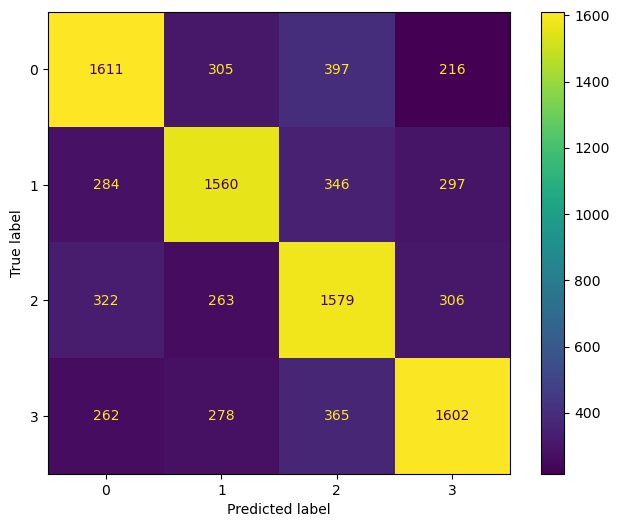

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix,
                            ConfusionMatrixDisplay,
                            precision_score,
                            recall_score,
                            accuracy_score,
                            f1_score)


def evaluate_model(y_preds, y_true):
    conf = confusion_matrix(y_test, y_preds)
    
    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
    display = ConfusionMatrixDisplay(conf)
    display.plot(ax=ax)
    
    print("All applicable scores are weighted")
    print(f"F1 Score : {f1_score(y_true, y_preds, average='weighted')}")
    print(f"Accuracy : {accuracy_score(y_true, y_preds)}")
    print(f"Recall   : {recall_score(y_true, y_preds, average='weighted')}")
    print(f"Precision: {precision_score(y_true, y_preds, average='weighted')}")
    
    
y_preds = clf.predict(x_test)
evaluate_model(y_preds, y_test)

## Simple Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(verbose=True, max_iter=1000)
res = clf.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       102624     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.54102D+04    |proj g|=  8.51111D+01

At iterate   50    f=  4.21954D+04    |proj g|=  5.06821D+02

At iterate  100    f=  4.15055D+04    |proj g|=  2.64479D+01

At iterate  150    f=  4.14657D+04    |proj g|=  2.03851D+01

At iterate  200    f=  4.14620D+04    |proj g|=  4.18753D+00

At iterate  250    f=  4.14617D+04    |proj g|=  1.67005D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    295    323      1     0     0   

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s finished


All applicable scores are weighted
F1 Score : 0.5652294900206438
Accuracy : 0.5654958470929651
Recall   : 0.5654958470929651
Precision: 0.5663239822516801


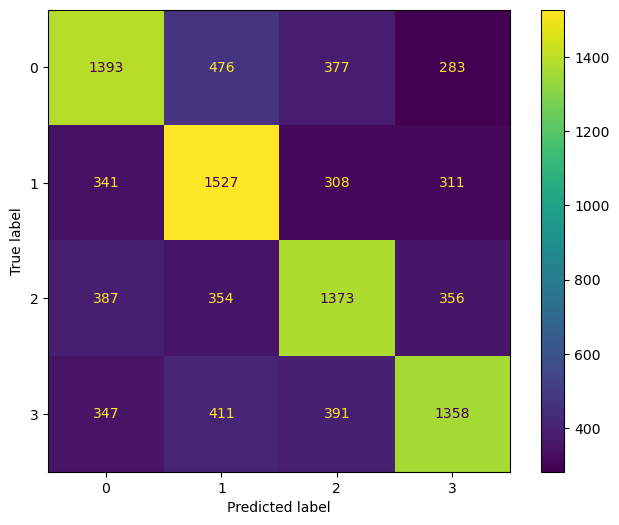

In [15]:
y_preds = clf.predict(x_test)
evaluate_model(y_preds, y_test)

## Grid Search With K-Neighbors Classification

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

pipe = Pipeline([('classifier', KNeighborsClassifier())])
param_grid = {
    'classifier__n_neighbors': list(range(3, 11)),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [2,3,4,5],
}

clf = GridSearchCV(pipe,
                  param_grid=param_grid,
                  cv=5,
                  n_jobs=20,
                  verbose=True)

best_clf = clf.fit(x_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
240 fits failed out of a total of 320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", line 215, in fit
    return self._

All applicable scores are weighted
F1 Score : 0.6659539051944832
Accuracy : 0.6614630241168818
Recall   : 0.6614630241168818
Precision: 0.7164739517679618


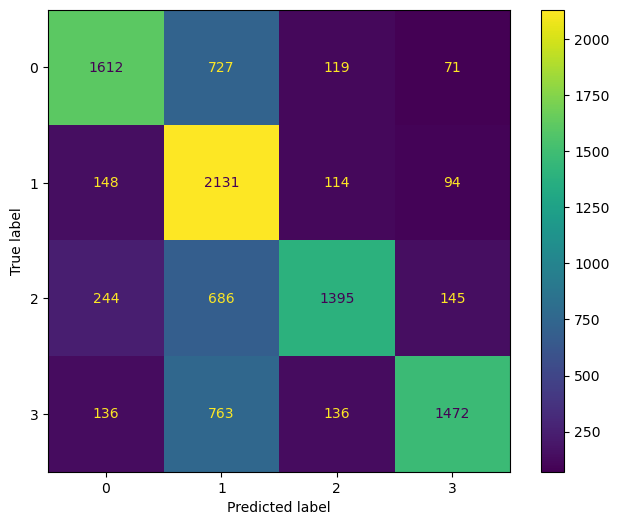

In [17]:
y_preds = best_clf.predict(x_test)
evaluate_model(y_preds, y_test)

In [18]:
print(best_clf.best_score_)
print(best_clf.best_params_)

0.6126845133850388
{'classifier__n_neighbors': 10, 'classifier__p': 2, 'classifier__weights': 'distance'}


## Support Vector Machine Classification

In [19]:
from sklearn.svm import SVC

clf = SVC(verbose=True, cache_size=32_000) # cache size specified in MB
clf.fit(x_train, y_train)

[LibSVM].............*...*
optimization finished, #iter = 16837
obj = -7854.467720, rho = -0.430750
nSV = 16035, nBSV = 7921
.............*...*
optimization finished, #iter = 16352
obj = -8253.914799, rho = 0.299660
nSV = 15974, nBSV = 8320
.............*...*
optimization finished, #iter = 16781
obj = -7646.613684, rho = 0.480083
nSV = 15768, nBSV = 7714
..............*...*
optimization finished, #iter = 17535
obj = -7750.379487, rho = 0.185095
nSV = 15757, nBSV = 7473
.............*....*
optimization finished, #iter = 17362
obj = -7802.943223, rho = 0.356571
nSV = 16029, nBSV = 7771
.............*....*
optimization finished, #iter = 17313
obj = -8151.488263, rho = 0.762700
nSV = 16288, nBSV = 8258
Total nSV = 36318


SVC(cache_size=32000, verbose=True)

All applicable scores are weighted
F1 Score : 0.6790746802904031
Accuracy : 0.6789752826978885
Recall   : 0.6789752826978885
Precision: 0.6812535402748964


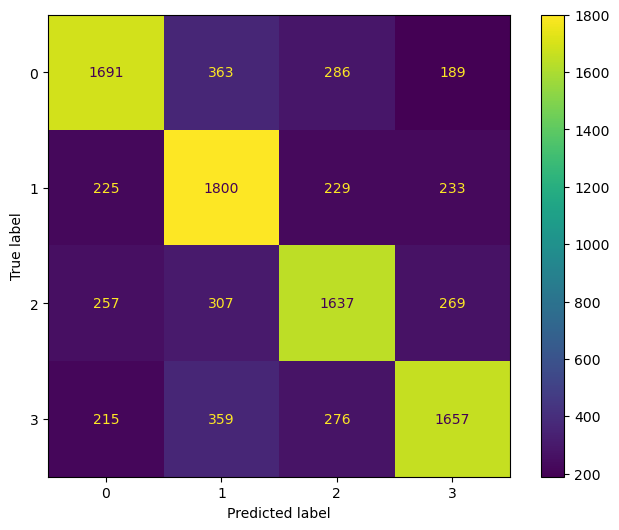

In [21]:
y_preds = clf.predict(x_test)
evaluate_model(y_preds, y_test)